# CH4 Time Series Forecasting
**Objective**: Validate selected model on test data and forecast atmospheric methane concentration

## Input Data
1. 'data/processed/CH4_train_log_preprocessed.csv'
2. 'data/processed/CH4_test_log_preprocessed.csv'

## Model Configuration
- 'results/CH4_train_best_model_config.json'

## Stages
1. load data and saved model configurations
2. rebuild and re-fit SARIMA model
3. generate out-of-sample forecasts
4. calculate test metrics
5. output: validation report

In [3]:
import sys
from pathlib import Path

# print absolute path to forecast_metrics.py
fm_path = Path.cwd().parent / 'src' / 'forecast_metrics.py'
print(f'Expected file path: {fm_path}')
print(f'File exists: {fm_path.exists()}')

Expected file path: C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src\forecast_metrics.py
File exists: True


In [4]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# add both repo root and src/ to path
repo_root = Path.cwd().parent
# sys.path.append(str(repo_root)) 
sys.path.insert(0, str(repo_root)) # insert at start to prioritize
sys.path.insert(0, str(repo_root / 'src')) # add src/ directly

# verify paths
print('\nPython Paths:')
for p in sys.path[:3]:
    print(f'--> {p}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Python Paths:
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src


# Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.forecast_metrics import forecast_metrics
print('forecast_metrics imported sucessfully!')

forecast_metrics imported sucessfully!


# Load the Data

In [13]:
# load the preprocessed train and test data (from ../data/processed/), and explicity set the frequency
CH4_train_preprocessed = pd.read_csv(
    '../data/processed/CH4_train_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_train_preprocessed.index = pd.DatetimeIndex(CH4_train_preprocessed.index, freq='W-SUN')

CH4_test_preprocessed = pd.read_csv(
    '../data/processed/CH4_test_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_test_preprocessed.index = pd.DatetimeIndex(CH4_test_preprocessed.index, freq='W-SUN')

# load the logged train and test data (from ../data/processed/), and explicity set the frequency
CH4_train_log_preprocessed = pd.read_csv(
    '../data/processed/CH4_train_log_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_train_log_preprocessed.index = pd.DatetimeIndex(CH4_train_log_preprocessed.index, freq='W-SUN')

# force a numeric conversion (due to issues with saving data to csv)
CH4_train_log_preprocessed['log_ch4'] = pd.to_numeric(CH4_train_log_preprocessed['log_ch4'], errors='coerce')

CH4_test_log_preprocessed = pd.read_csv(
    '../data/processed/ch4_test_log_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_test_log_preprocessed.index = pd.DatetimeIndex(CH4_test_log_preprocessed.index, freq='W-SUN')

# force a numueric conversion (due to issues with saving data to csv)
CH4_test_log_preprocessed['log_ch4'] = pd.to_numeric(CH4_test_log_preprocessed['log_ch4'], errors='coerce')

In [14]:
CH4_train_preprocessed.head()

,CH4
date,
1983-05-08,1637.32925
1983-05-15,1645.17000
1983-05-22,1645.17000
1983-05-29,1637.32925
1983-06-05,1630.24525


In [15]:
CH4_test_preprocessed.head()

,CH4
date,
2023-10-29,1954.9125
2023-11-05,1954.9125
2023-11-12,1954.8800
2023-11-19,1946.6300
2023-11-26,1946.6625


In [16]:
CH4_train_log_preprocessed.head()

,log_ch4
date,
1983-05-08,7.40081
1983-05-15,7.40560
1983-05-22,7.40560
1983-05-29,7.40081
1983-06-05,7.39649


In [17]:
CH4_test_log_preprocessed.head()

,log_ch4
date,
2023-10-29,7.57810
2023-11-05,7.57810
2023-11-12,7.57808
2023-11-19,7.57385
2023-11-26,7.57386


In [18]:
# Verify the data reloaded correctly
print("Training data shape after reload:", CH4_train_log_preprocessed.shape)
print("Test data shape after reload:", CH4_test_log_preprocessed.shape)

# Check the last training point vs first test point
print("Last training date:", CH4_train_log_preprocessed.index[-1])
print("First test date:", CH4_test_log_preprocessed.index[0])
print("Gap between train end and test start:", CH4_test_log_preprocessed.index[0] - CH4_train_log_preprocessed.index[-1])

Training data shape after reload: (2112, 1)
Test data shape after reload: (63, 1)
Last training date: 2023-10-22 00:00:00
First test date: 2023-10-29 00:00:00
Gap between train end and test start: 7 days 00:00:00


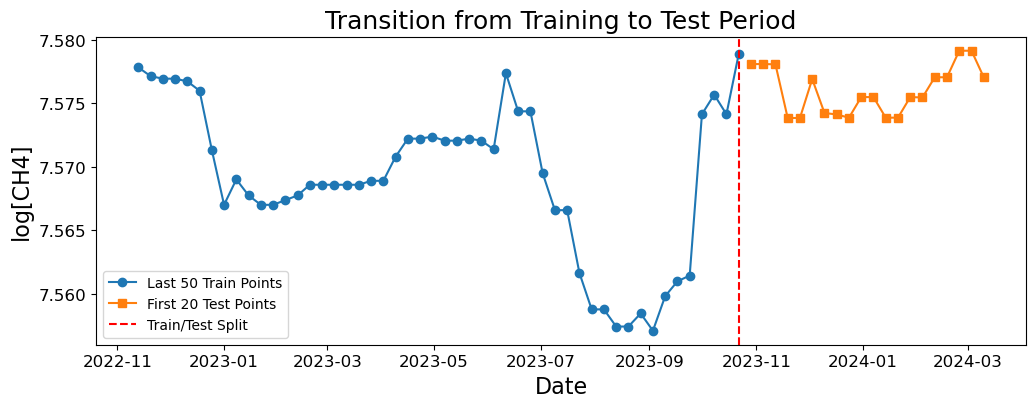

In [21]:
# Plot the transition from train to test
plt.figure(figsize=(12,4))
plt.plot(CH4_train_log_preprocessed.index[-50:], CH4_train_log_preprocessed.values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(CH4_test_log_preprocessed.index[:20], CH4_test_log_preprocessed.values[:20],
         label='First 20 Test Points', marker='s')
plt.axvline(x=CH4_train_log_preprocessed.index[-1], color='red', linestyle='--', 
            label='Train/Test Split')
plt.legend()
plt.title('Transition from Training to Test Period', fontsize=18)
plt.ylabel('log[CH4]', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# Load the model configuration and re-fit model

In [22]:
import json

with open('../results/CH4_train_best_model_config.json', 'r') as f:
    config = json.load(f)

model = SARIMAXResults.load('../results/CH4_best_sarima.pkl')

In [24]:
# Rebuild and re-fit model
try:
    model = SARIMAX(
        CH4_train_log_preprocessed,
        order=config['order'],
        seasonal_order=config['seasonal_order'],
        trend=config.get('trend', 'n'),
        enforce_stationarity=config.get('enforce_stationarity', False),
        enforce_invertibility=config.get('enforce_invertibility', False)
    )

    CH4_model_results = model.fit(method=config['fit_method'])

    print(f"Model re-fitted using data from {config['training_data_range']['start']} to {config['training_data_range']['end']}")

except Exception as e:
    print(f'Error refitting model: {e}')

Model re-fitted using data from 1983-05-08 to 2023-10-22


In [25]:
# verify the model order and seasonal order
print('"CH4_best_sarima": SARIMA(1,1,0)(1,0,0)[52]')
print('Order (p, d, q):', model.order)
print('Seasonal order (P, D, Q, s):', model.seasonal_order)

"CH4_best_sarima": SARIMA(1,1,0)(1,0,0)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 0, 52)


# Forecast the CH4 time series data

In [26]:
# forecast the CH4 best SARIMA model results: SARIMA(1,1,0)(1,0,0)[52], trend = 'n', method = 'lbfgs'

# create the forecast object  
forecast_object = CH4_model_results.get_forecast(steps=len(CH4_test_preprocessed))

# get mean forecast and confidence intervals
forecast_logged = forecast_object.predicted_mean
forecast_conf_int_logged= forecast_object.conf_int()

# undo log (exponentiate), back-transform the logged values to original scale
forecast = np.exp(forecast_logged)
forecast_conf_int = np.exp(forecast_conf_int_logged)

# set the forecast index to match the test set index
forecast.index = CH4_test_preprocessed.index
forecast_conf_int.index = CH4_test_preprocessed.index

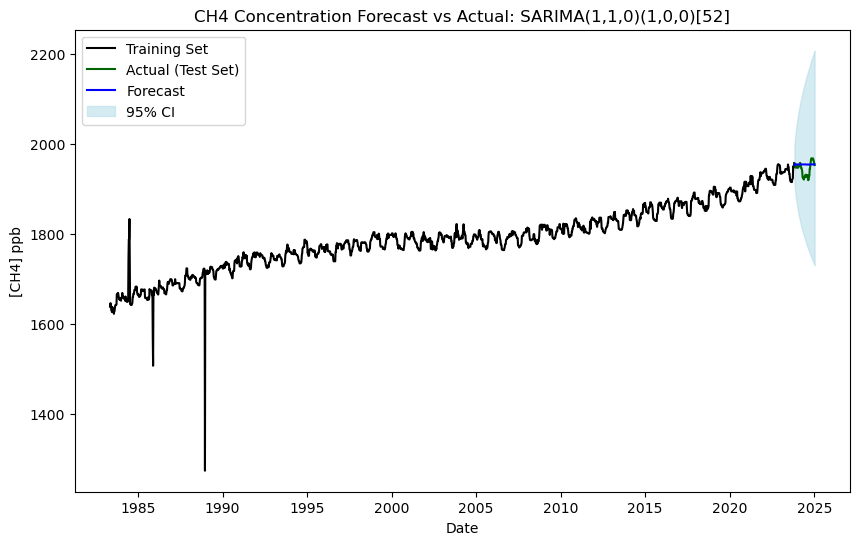

In [27]:
# plot the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_train_preprocessed.index, CH4_train_preprocessed, label='Training Set', color='black')
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(1,1,0)(1,0,0)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

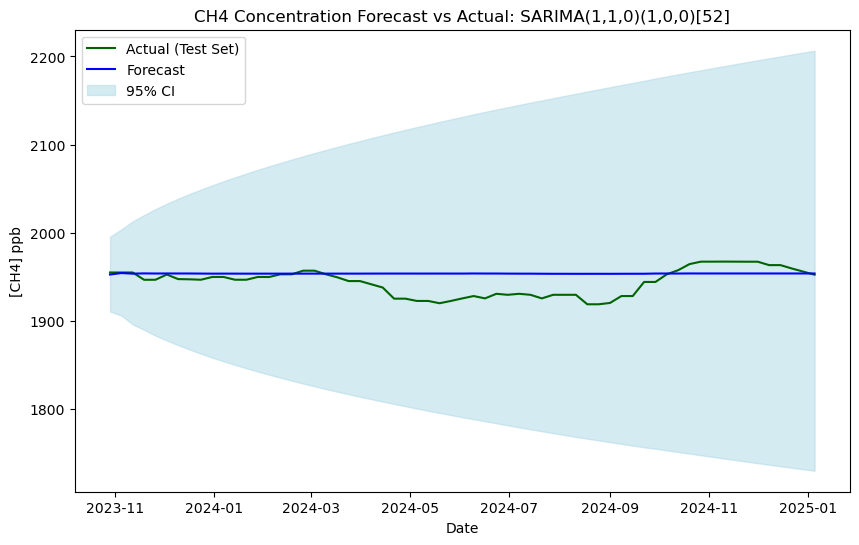

In [28]:
# focus on the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(1,1,0)(1,0,0)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [29]:
# Forecast metrics

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for SARIMA Predication (1,1,0)(1,0,0,52)')  
forecast_metrics(CH4_test_preprocessed, forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (1,1,0)(1,0,0,52)


{'MAE': 13.987, 'MSE': 316.27, 'RMSE': 17.784, 'MAPE': 0.723}

## Rolling Forecast

In [30]:
print(CH4_train_log_preprocessed.index.freq)
print(CH4_test_log_preprocessed.index.freq)
print(CH4_train_preprocessed.index.freq)
print(CH4_test_preprocessed.index.freq)

<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>


In [24]:
# rolling forecast SARIMA(1,1,0)(1,0,0)[52]

# Initialize variables
CH4_train_log_preprocessed.index.freq = 'W-SUN'
CH4_test_log_preprocessed.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_log_preprocessed['log_ch4_ppb'].copy()  # initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

# Rolling forecast loop
for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,0,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_log_preprocessed['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

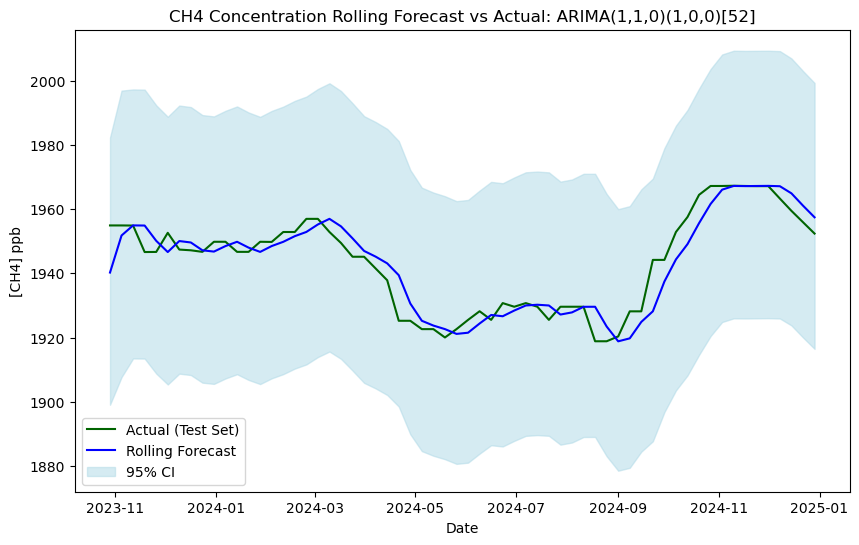

In [26]:
# plot the rolling forecast results 

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(1,1,0)(1,0,0)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [27]:
# evaluation metrics for rolling forecast of SARIMA(1,1,0)(1,0,0)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,0,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,0,52)


{'MAE': 3.967, 'MSE': 28.089, 'RMSE': 5.3, 'MAPE': 0.204}

### Autocorrelation analysis of rolling forecast model residuals

In [28]:
# Calculate the residuals from the rolling forecast models 

# SARIMA(1,1,0)(1,0,0)[52]
CH4_rolling_forecast_residuals = (np.exp(CH4_test_log_preprocessed['log_ch4_ppb']) - CH4_rolling_forecast)
CH4_rolling_forecast_residuals = pd.Series(
    CH4_rolling_forecast_residuals, 
    index=CH4_test_preprocessed.index
)

PACF function uses the Yule-Walker method to calculate the partial autocorrelation function (OLS method).  To avoid overfitting and ensure numerical stability, statsmodels enforces that # lags < 50% of the # observations. Since my test set is 67 data points in length, I am limited to 32 lags.  Two possible ways forward with the residuals test for autocorrelation:

1. move forward as is and interpret ACF based on 52 lags and PACF based on 32 lags.  
2. Go back and change the test set to include 106 data points (nlags < len(residuals) // 2).  

I will choose option 1 and determine if I need to change the data split ratio after I see the results.

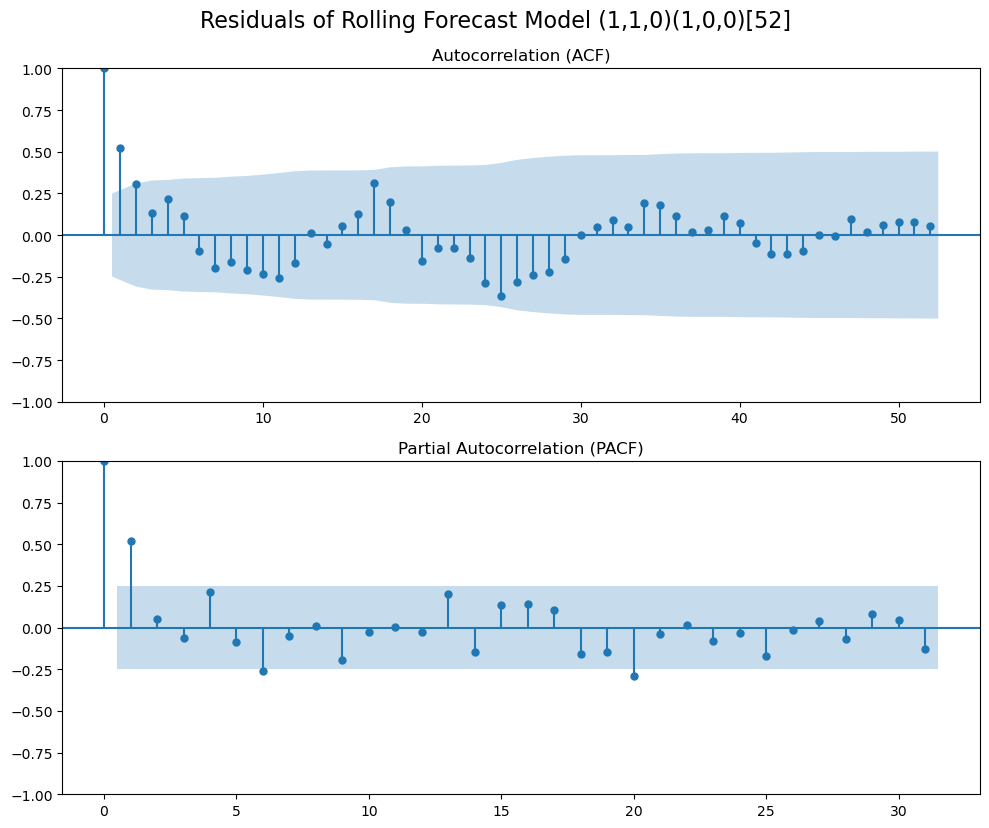

In [30]:
fig, axs = plt.subplots(2,1, figsize=(10,8))

plot_acf(
    CH4_rolling_forecast_residuals, 
    lags=52, 
    ax=axs[0],
    title='Autocorrelation (ACF)'
)

plot_pacf(
    CH4_rolling_forecast_residuals, 
    lags=31, 
    ax=axs[1],
    title='Partial Autocorrelation (PACF)'
)

plt.tight_layout()
plt.suptitle('Residuals of Rolling Forecast Model (1,1,0)(1,0,0)[52]', fontsize=16, y=1.03)
plt.show()

All lags are within the CI (95%) so aren't significant, but the pattern suggests that there is possible room to improve the model tune.  

In [31]:
# Ljung-Box test

lb_test = acorr_ljungbox(CH4_rolling_forecast_residuals, lags=[1,4,26,52], return_df=True)
    
print('Ljung-Box Test Results for SARIMA(1,1,0)(1,0,0)[52] Rolling Forecast Model\n')
print(lb_test)

Ljung-Box Test Results for SARIMA(1,1,0)(1,0,0)[52] Rolling Forecast Model

       lb_stat     lb_pvalue
1    17.562461  2.780229e-05
4    28.134149  1.171591e-05
26  100.856454  9.242086e-11
52  149.275936  2.463158e-11


# Test the (1,1,0)(1,0,0,52) model with trend = 'c'

In [33]:
model_trendc = SARIMAX(
    CH4_train_log_preprocessed,
    order = (1,1,0),
    seasonal_order = (1,0,0,52),
    trend = 'ct',
    enforce_stationarity = False,
    enforce_invertibility = False
)

results_trendc = model_trendc.fit(disp = False)    
results_trendc.summary()

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            log_ch4   No. Observations:                 2112
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 52)   Log Likelihood                6349.224
Date:                            Thu, 02 Oct 2025   AIC                         -12688.448
Time:                                    17:20:49   BIC                         -12660.301
Sample:                                05-08-1983   HQIC                        -12678.128
                                     - 10-22-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.257      0.797      -0.001       0.001
drift       6.695e-09    8.8e-07      0.008      0.994   -1.72e-06    1.73e-06
ar.L1         -0.4266      0.001   -321.720      0.000      -0.429      -0.424
ar.S.L52       0.0097      0.067      0.146      0.884      -0.121       0.141
sigma2         0.0001   2.41e-07    496.169      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  23.17   Jarque-Bera (JB):          37673024.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                           -13.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       665.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
model_trendt = SARIMAX(
    CH4_train_log_preprocessed,
    order = (2,1,1),
    seasonal_order = (1,0,0,52),
    trend = 't',
    enforce_stationarity = False,
    enforce_invertibility = False
)

results_trendt = model_trendt.fit(disp = False)    
results_trendt.summary()

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         log_ch4_ppb   No. Observations:                 2111
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood                6453.142
Date:                             Wed, 01 Oct 2025   AIC                         -12894.284
Time:                                     17:55:58   BIC                         -12860.513
Sample:                                 05-08-1983   HQIC                        -12881.902
                                      - 10-15-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.163e-08    2.3e-07      0.225      0.822   -3.99e-07    5.02e-07
ar.L1          0.0212      0.017      1.275      0.202      -0.011       0.054
ar.L2         -0.0098      0.009     -1.053      0.292      -0.028       0.008
ma.L1         -0.5883      0.017    -34.332      0.000      -0.622      -0.555
ar.S.L52       0.0095      0.060      0.159      0.874      -0.107       0.126
sigma2         0.0001   2.71e-07    407.128      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):          47658213.94
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                           -18.85
Prob(H) (two-sided):                  0.00   Kurtosis:                       747.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
# forecast the CH4 best SARIMA model results: SARIMA(1,1,1)(0,0,0)[52], trend = 't', method = 'lbfgs'

# create the forecast object  
forecast_object2 = results_trendt.get_forecast(steps=len(CH4_test_preprocessed))

# get mean forecast and confidence intervals
forecast_logged = forecast_object2.predicted_mean
forecast_conf_int_logged= forecast_object2.conf_int()

# undo log (exponentiate), back-transform the logged values to original scale
forecast2 = np.exp(forecast_logged)
forecast_conf_int2 = np.exp(forecast_conf_int_logged)

# set the forecast index to match the test set index
forecast2.index = CH4_test_preprocessed.index
forecast_conf_int2.index = CH4_test_preprocessed.index

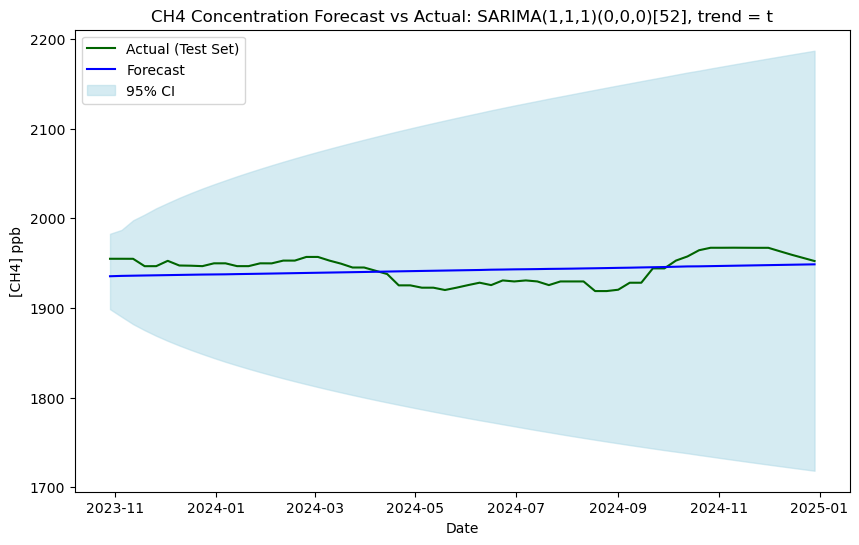

In [99]:
# focus on the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast2.index, forecast2, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(1,1,1)(0,0,0)[52], trend = t') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [100]:
# Forecast metrics for model with trend = 't'

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for SARIMA Predication (1,1,1)(0,0,0,52), trend = t')  
forecast_metrics(CH4_test_preprocessed, forecast2)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (1,1,1)(0,0,0,52), trend = t


{'MAE': 13.98, 'MSE': 228.794, 'RMSE': 15.126, 'MAPE': 0.72}

In [ ]:
Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (1,1,0)(1,0,0,52), trend = c
{'MAE': 13.437, 'MSE': 220.413, 'RMSE': 14.846, 'MAPE': 0.692}

# CH4 forecasting

## Load the full, preprocessed dataset

In [25]:
CH4_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

## Re-train the model on the full dataset

In [26]:
print(CH4_preprocessed.index.freq)
print(CH4_preprocessed.index.min())
print(CH4_preprocessed.index.max())

<Week: weekday=6>
1983-05-08 00:00:00
2025-04-06 00:00:00


### Log transform and save as CSV

In [27]:
# log transform the entire dataset
CH4_preprocessed_logged = np.log(CH4_preprocessed) 

In [28]:
# define output path
from pathlib import Path

output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [29]:
# save the logged full CH4 dataset (CH4_preprocessed)
output_path = output_dir / 'ch4_preprocessed_logged.csv'
(
    CH4_preprocessed_logged
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_preprocessed_logged data saved to:\n{output_path}')
print(f'Shape: {CH4_preprocessed_logged.shape}')

CH4_preprocessed_logged data saved to:
..\data\processed\ch4_preprocessed_logged.csv
Shape: (2188, 1)


C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9362.643
Date:                                 Wed, 11 Jun 2025   AIC                         -18713.286
Time:                                         18:19:21   BIC                         -18679.439
Sample:                                     05-08-1983   HQIC                        -18700.883
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0701      0.016      4.316      0.000       0.038       0

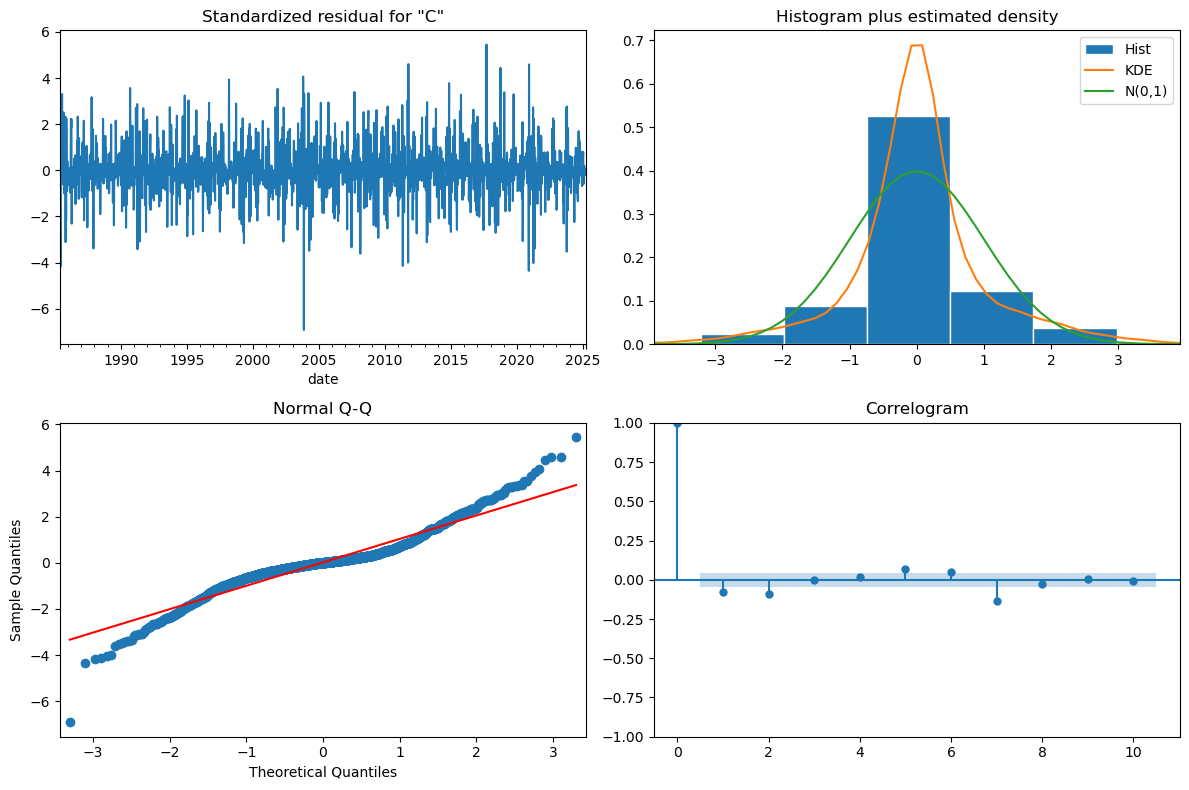

In [139]:
# I will re-train the SARIMA(2,1,0)(1,0,2)[52] model with the entire dataset 

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- AIC = -18713, BIC = -18679, which are good, low values
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- all coefficients are statistically significant
- Standardized residuals: random, no clear patterns

negatives:
- The Jarque-Bera test and QQ plot shows non-normal distribution with heavy tails
- Ljung-Box test shows that some autocorrelation remains, and can be seen at lag 1, mayb lag 2 of the correlogram



                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood                9383.164
Date:                                 Wed, 11 Jun 2025   AIC                         -18752.329
Time:                                         18:28:18   BIC                         -18712.844
Sample:                                     05-08-1983   HQIC                        -18737.860
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0258      0.164      0.157      0.875      -0.296       0

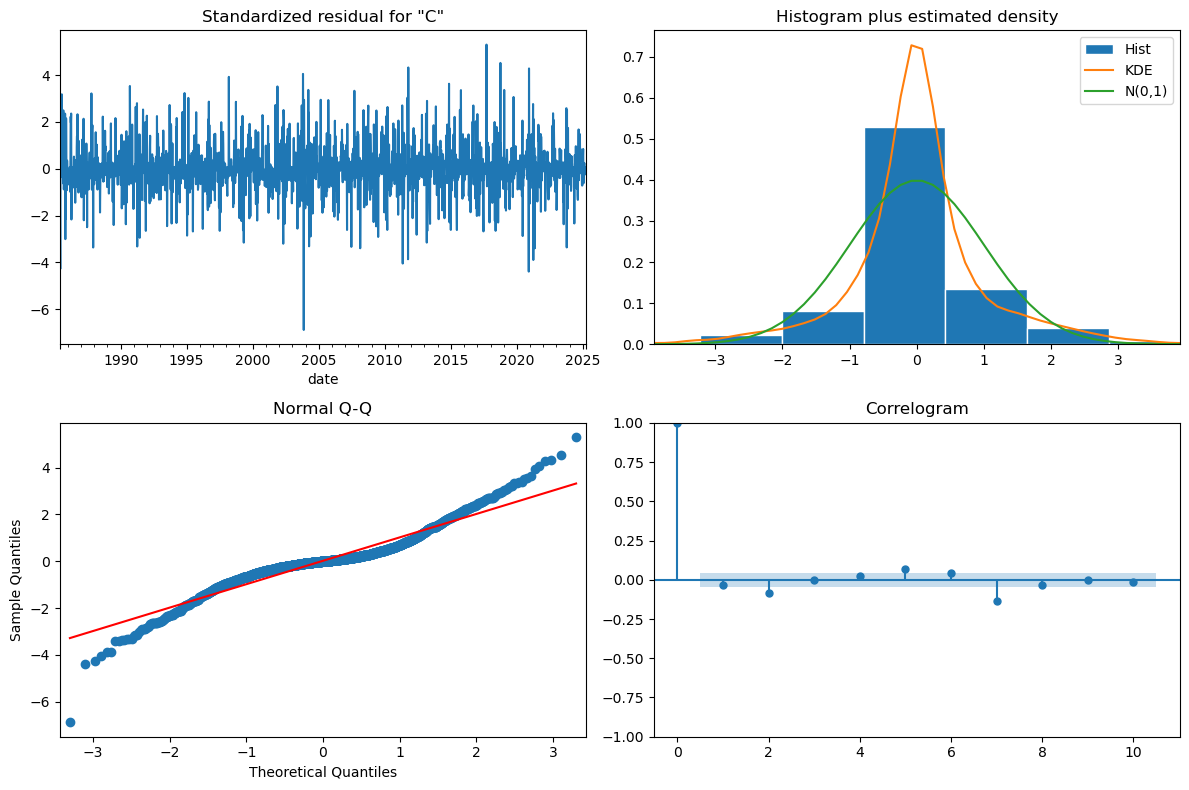

In [140]:
# I will try adding a non-seasonal MA term to address the autocorrelation observed at lag 1
# SARIMA(2,1,1)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,1),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9445.101
Date:                                 Wed, 11 Jun 2025   AIC                         -18880.202
Time:                                         18:36:45   BIC                         -18851.997
Sample:                                     05-08-1983   HQIC                        -18869.867
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0490      0.016     -2.999      0.003      -0.081      -0

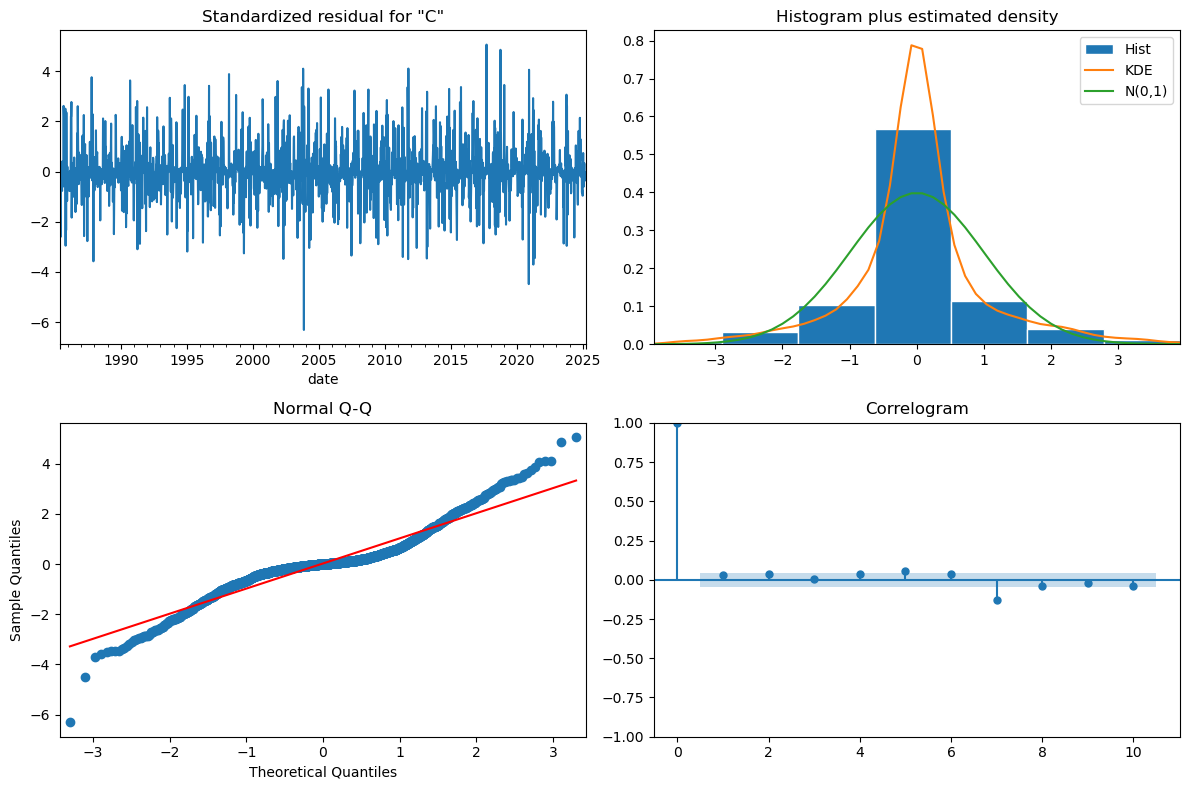

In [141]:
# adding the non-seasonal MA(1) term improved the model by eliminating the autocorrelation and lag 1, 
# increasing the log likelihood, and decreasing both AIC and BIC values.  However, now, non-seasonal terms 
# ar(L1) and ma(l1) became statistically insignificant.  
# SARIMA(1,1,0)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(1,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- log-likelihood increased from 9362 to 9445
- AIC decreased from -18713 to -18880
- BIC decreased from -18679 to -18852
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- Standardized residuals: random, no clear patterns
- Ljung-Box test and correlogram present homoscedastic behavior

negatives:
- the seasonal AR term (AR.S.L52) is not statistically significant.  However, removing this term (i.e. (1,1,0)(0,0,[1,2])[52]) produced substantially worse metrics, data histogram, QQ plot and correlogram.  
- The Jarque-Bera test and QQ plot still shows non-normal distribution with heavy tails

The SARIMA(1,1,0)(1,0,2)[52] is a better and more simple model compared to SARIMA(2,1,0)(1,0,2)[52] on the full dataset.  

## Test New Parameters on Train & Test Sets

In [142]:
# Rolling forecast loop for SARIMA(1,1,0)(1,0,2)[52]

# Initialize variables
CH4_train_logged.index.freq = 'W-SUN'
CH4_test_logged.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_logged['log_ch4_ppb'].copy()  # Your initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,2,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_logged['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

In [143]:
# verify the order and seasonal order
print('"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model_fit.model.order)
print('Seasonal order (P, D, Q, s):', model_fit.model.seasonal_order)

"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


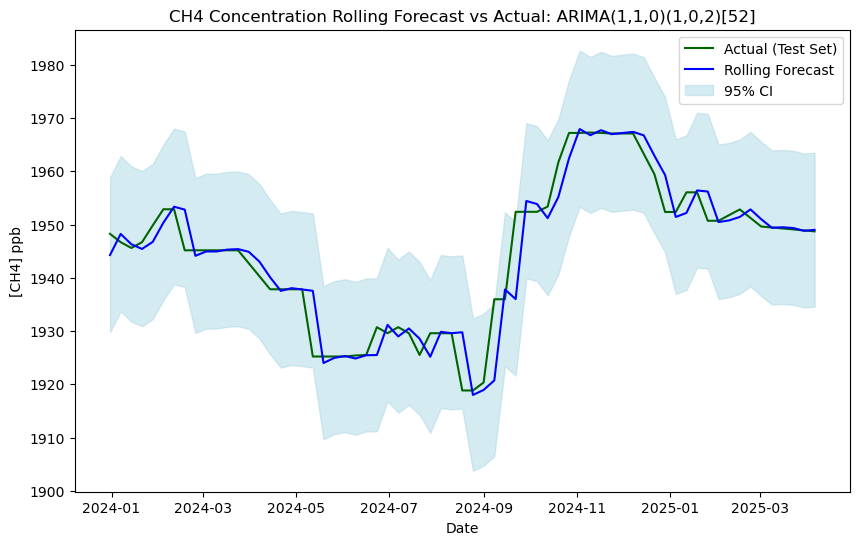

In [144]:
# plot the rolling forecast results for SARIMA(1,1,0)(1,0,2)[52]

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(1,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [145]:
# Evaluation metrics for rolling forecast of SARIMA(1,1,0)(1,0,2)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)


{'MAE': 2.378, 'MSE': 17.302, 'RMSE': 4.16, 'MAPE': 0.122, 'R-squared': 0.903}

**Compare SARIMA(1,1,0)(1,0,2,52) vs SARIMA(2,1,0)(1,0,2,52)**

Evaluation Metrics for Rolling Forecast, SARIMA(2,1,0)(1,0,2,52):
- {'MAE': 2.438, 'MSE': 17.13, 'RMSE': 4.139, 'MAPE': 0.125, 'R-squared': 0.904}

The differences in evaluation metrics are minimal.  Considering that the simpler model has better log likelihood, AIC, and BIC scores and results in residuals that are homescedastic and no autocorrelation, SARIMA(1,1,0)(1,0,2,52) is the better model.    

# Save the Final Model Configuration

In [146]:
import json
from datetime import datetime

model_config = {
    'model_type': 'SARIMAX',
    'order': (1,1,0),
    'seasonal_order': (1,0,2,52),
    'trend': 'n',
    'enforce_stationarity': False,
    'envorce_invertibility': False,
    'training_date_range': {
        'start': CH4_preprocessed_logged.index[0].strftime('%Y-%m-%d'),
        'end': CH4_preprocessed_logged.index[-1].strftime('%Y-%m-%d')
    },
    'fit_method': 'lbfgs',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# save as JSON file
with open('../results/CH4_full_dataset_best_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('CH4 full dataset model configuration saved.  Re-fit in next notebook.')

CH4 full dataset model configuration saved.  Re-fit in next notebook.
